### 1. Preliminaries

In [1]:
try: import fastkaggle

except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

competition = 'paddy-doctor-diseases-v2'
path = setup_comp(competition, install='fastai "timm>=0.6.2.dev0"')

from fastai.vision.all import *
set_seed(42)

# train images
train_path = path / 'train_images'
train_files = get_image_files(train_path)

# test images
test_path = path/'test_images'
test_files = get_image_files(test_path).sorted()

# train labels
train_df = pd.read_csv(path / 'train.csv')
train_df.head()

,image_id,label,variety,age
0,102234.jpg,bacterial_leaf_blight,45,45
1,102735.jpg,bacterial_leaf_blight,45,45
2,103544.jpg,bacterial_leaf_blight,45,45
3,103714.jpg,bacterial_leaf_blight,45,45
4,103827.jpg,bacterial_leaf_blight,45,45


### 2. Dataloaders

In [2]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(train_path)

In [3]:
dls = ImageDataLoaders.from_folder(
    train_path, 
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

### 3. Model training

In [4]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

And that's it, 16 epochs to get the best baseline for the price 

In [5]:
learn.fine_tune(16, 0.005)
#learn.fine_tune(2, 0.005)

epoch,train_loss,valid_loss,error_rate,time
0,1.809070,1.088804,0.344376,02:26


epoch,train_loss,valid_loss,error_rate,time
0,0.757749,0.448744,0.140986,02:17
1,0.456639,0.344983,0.103236,02:19
2,0.418523,0.390870,0.117874,02:18
3,0.389006,0.353229,0.110169,02:18
4,0.334059,0.301345,0.088598,02:17
5,0.304592,0.294063,0.089753,02:16
6,0.236659,0.313776,0.083590,02:16
7,0.202414,0.214779,0.059707,02:16
8,0.143856,0.155020,0.037750,02:16
9,0.109134,0.151907,0.039291,02:17


### 4. Predictions

In [6]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0243)

In [7]:
# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0231)

#### Predictions on test set

In [8]:
# test images
test_path = path/'test_images'
test_files = get_image_files(test_path).sorted()
test_classes = [f.parent.name for f in test_files]

probs, _ = learn.tta(dl=dls.test_dl(test_files))
preds = probs.argmax(dim=1)
pred_classes = dls.vocab[preds]

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

cls_report = classification_report(test_classes, pred_classes, 
                                   digits=5)
print(cls_report)
acc = accuracy_score(test_classes, pred_classes)

                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.96970   0.98462   0.97710       130
   bacterial_leaf_streak    0.94231   0.98000   0.96078       100
bacterial_panicle_blight    1.00000   0.97778   0.98876        90
        black_stem_borer    0.97849   0.90099   0.93814       101
                   blast    0.97441   0.97234   0.97338       470
              brown_spot    0.97976   0.95652   0.96800       253
            downy_mildew    0.96532   0.95977   0.96254       174
                   hispa    0.96128   0.97912   0.97011       431
             leaf_roller    0.97297   0.98630   0.97959       219
                  normal    0.98760   0.99376   0.99067       481
                  tungro    0.99217   0.97436   0.98318       390
        white_stem_borer    0.95420   0.98425   0.96899       254
       yellow_stem_borer    1.00000   0.98026   0.99003       152

                accuracy                        0.97565      3245
        

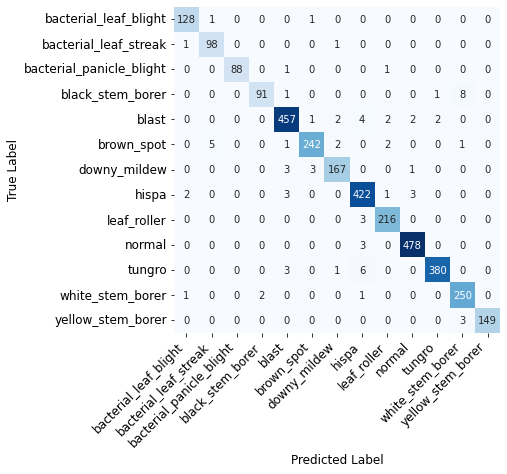

[[128   1   0   0   0   1   0   0   0   0   0   0   0]
 [  1  98   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0  88   0   1   0   0   0   1   0   0   0   0]
 [  0   0   0  91   1   0   0   0   0   0   1   8   0]
 [  0   0   0   0 457   1   2   4   2   2   2   0   0]
 [  0   5   0   0   1 242   2   0   2   0   0   1   0]
 [  0   0   0   0   3   3 167   0   0   1   0   0   0]
 [  2   0   0   0   3   0   0 422   1   3   0   0   0]
 [  0   0   0   0   0   0   0   3 216   0   0   0   0]
 [  0   0   0   0   0   0   0   3   0 478   0   0   0]
 [  0   0   0   0   3   0   1   6   0   0 380   0   0]
 [  1   0   0   2   0   0   0   1   0   0   0 250   0]
 [  0   0   0   0   0   0   0   0   0   0   0   3 149]]


In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

class_names = dls.vocab
plot_heatmap(test_classes, pred_classes, class_names, ax, title="Resnet34")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(test_classes, pred_classes)
print(cm)

#### Acknowledgements
1. https://www.kaggle.com/code/fmussari/fast-resnet34-with-fastai
